<a href="https://colab.research.google.com/github/jazoza/mad/blob/main/02_MAD_import_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Colab Notebook](https://colab.research.google.com/drive/1rlgOJ6TXEM3WIlfeCmgb-h3wvkZ_xxEZ#scrollTo=KL-xWvxSwAqq)

In [ ]:
!pip install susi

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import susi
import json
import pickle
import requests
import pandas as pd
from susi.SOMPlots import plot_nbh_dist_weight_matrix, plot_umatrix, plot_estimation_map, plot_som_histogram
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file, save
from bokeh.io import output_notebook
output_notebook()

## Add .pkl files to your own GDrive

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Getting the right PATH
When your GDrive is loaded, find the folder containing the .pkl files that were provided. Than right click the folder containing it and select `Copy path`.
Paste it in the cell below replacing the path that follows the `%cd` command

In [1]:
!pwd 
!ls

/content
sample_data


In [ ]:
# change into the directory where you store your files 
%cd /content/drive/MyDrive/ #add destination

# Import Datasets

In [ ]:
radio_data_path = 'radio.pkl'
fma_data_path = 'fma.pkl'
xenocanto_data_path = 'xenocanto.pkl'

radio_data = pickle.load(open(radio_data_path, 'rb'))
# /\.\/(\w*?)\//g
data_length = len(radio_data['features'])
radio_data['known'] = ['NaN'] * data_length
index = 0
for path in radio_data['Sample_audio']:
    if './known/' in path:
       radio_data['known'][index] = 'known'
    else:
        radio_data['known'][index] = 'unknown'
    index+=1

fma_data = pickle.load(open(fma_data_path, 'rb'))

xenocanto_data = pickle.load(open(xenocanto_data_path, 'rb'))

datasets = {
    "fma": fma_data,
    "radio": radio_data,
    "xenocanto": xenocanto_data,
}

In [ ]:
# @title Choose the data you want to work with
# @markdown `You can select between FMA, Xenocanto and Radio`
selector = "fma" # @param ["fma", "radio", "xenocanto"]
current_df = datasets[selector]
data_length = len(current_df)
train_amount = math.floor(len(current_df) / 4) * 3
current_df_train = current_df.loc[0:train_amount-1]
train_data = current_df.loc[0:train_amount-1]
print(len(train_data))
train_data = [np.ravel(item) for item in train_data['mfcc']]
print(len(train_data))
test_data = current_df.loc[train_amount:data_length-1]
current_df_test = current_df.loc[train_amount:data_length-1]
print(len(test_data))
test_data = [np.ravel(item) for item in test_data['mfcc']]
print(len(test_data))



3000
3000
1000
1000


In [ ]:
#@markdown ### `5 * sqrt(number of training samples)`
#@markdown this returns "ideal" grid size

#@markdown but can be changed to try out 

train_data_length = len(train_data)

# for d in train_data:
#     print(d.shape)
# 5 * sqrt(number of training samples)
grid = math.ceil(5 * math.sqrt(train_data_length))
grid = math.floor(math.sqrt(grid))
print(grid)

16


# Train the SOM

`If you want to use pre-trained SOM skip to the` [Load SOM](#scrollTo=GZrbxyFIJQmI) `cell`

In [ ]:
# @markdown `Set the number of iterations the SOM should execute` 
iterations = 10000 # @param {type:"number"}
som = susi.SOMClustering(
    n_rows=grid,
    n_columns=grid,
    n_iter_unsupervised=iterations
)
som.fit(train_data)
# print("SOM fitted!")

In [ ]:
#@title Saving SOM { display-mode: "form" }
#@markdown use the following cell to save the som to your GDrive. Do not forget the `.pkl` extension, and make sure your runtime did not disconnect.
som_fma = som
filename = 'what_a_som.pkl' #@param {type:"string"}
with open(filename, 'wb') as _file:
    pickle.dump(som_fma, _file)

## Load SOM 

In [ ]:
#@markdown `Be sure to be in the correct folder!`
som_path = 'som_fma.pkl' #@param {type: "string"}
som = pickle.load(open(som_path, 'rb'))

## Show SOM

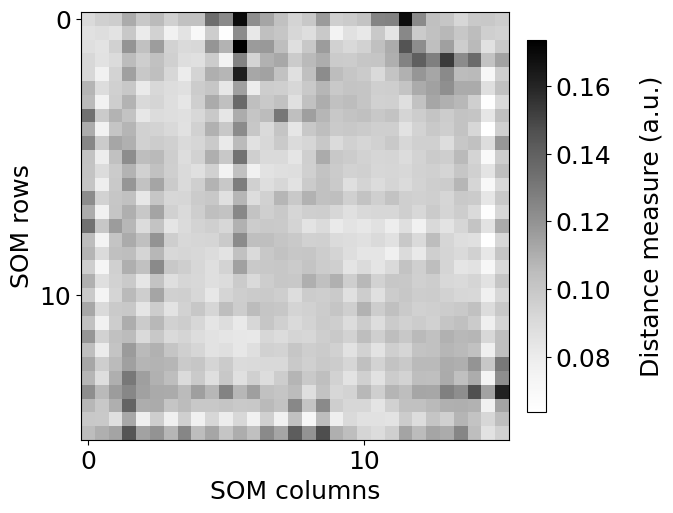

In [ ]:
u_matrix = som.get_u_matrix()
plot_umatrix(u_matrix, grid, grid)
plt.show()

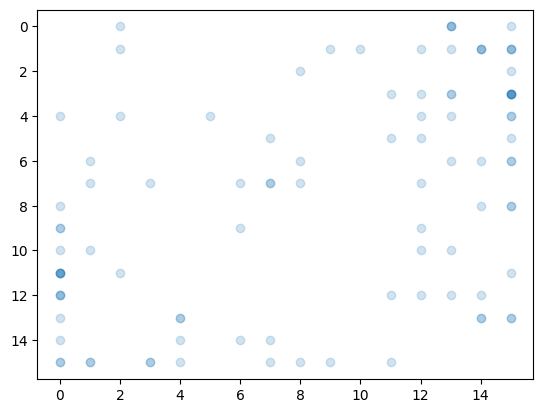

In [ ]:
y = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
clusters = som.get_clusters(np.asarray(test_data[0:100]))
plt.scatter(x=[c[1] for c in clusters], y=[c[0] for c in clusters], alpha=0.2)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# @title Preparing data for customized node visualization  { display-mode: "form" }
# @markdown 
data_from_node = []
for x in range(grid):
    for y in range(grid):
        obj = {"x": x, "y": y}
        data = som.get_datapoints_from_node((x, y))
        obj["data"] = data
        obj["val"] = len(data)
        data_from_node.append(obj)


def get_min_max(data):
    values_arr = [x["val"] for x in data]
    minimum = min(values_arr)
    maximum = max(values_arr)
    avg = np.average(values_arr)
    return [minimum, maximum, avg]


# from https://stackoverflow.com/questions/1969240/mapping-a-range-of-values-to-another
def map(value, original_min, original_max, mapped_min, mapped_max):
    # Figure out how 'wide' each range is
    leftSpan = original_max - original_min
    rightSpan = mapped_max - mapped_min

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - original_min) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return round(mapped_min + (valueScaled * rightSpan))


def clamp(n, smallest, largest):
    return max(smallest, min(n, largest))



def make_color_palette(data):
    minmax = get_min_max(data)
    length = len(data)
    for i in range(length):
        item = data[i]
        r = map(item["val"], minmax[0], minmax[2], 0, 155)
        r = clamp(r, 0, 255)
        g = clamp(map(item["val"], minmax[0], minmax[2], 0, 155), 0, 255)
        b = clamp(map(item["val"], minmax[0], minmax[2], 100, 255), 0, 255)
        color = "#%02x%02x%02x" % (r, g, b)
        item["color-hex"] = color
        color = [r / 255, g / 255, b / 255]
        item["color-rgb"] = color


make_color_palette(data_from_node)


In [ ]:
# @title List all the Columns of Dataset { display-mode: "form" }
current_df.columns.values.tolist()

['id',
 'Info',
 'Description',
 'Genre',
 'album_date_released',
 'track_date_recorded',
 'artist_location',
 'fingerprints',
 'bmus',
 'features',
 'mfcc']

In [ ]:
# @title Prepare data given the field to investigate { display-mode: "form" }
field = "Genre" # @param {type:"string"}
fields = current_df_test[field].unique().tolist()

field_visualizations = {}

for item in fields:
  field_visualizations[item] = []

for key in field_visualizations:
  print(key)
  for item in data_from_node:
    for index in item['data']:
      genre = current_df[field].loc[index]
      if genre == key: 
        temp_obj = {
            "x": item["x"],
            "y": item["y"],
            "loc": [int(item["x"]), int(item["y"])],
            "index": index
        }
        field_visualizations[key].append(temp_obj)
print(field_visualizations) 

Hip-Hop
Electronic
Rock
Folk
Experimental
Pop
Instrumental
International
{'Hip-Hop': [{'x': 0, 'y': 1, 'loc': [0, 1], 'index': 2476}, {'x': 0, 'y': 6, 'loc': [0, 6], 'index': 301}, {'x': 0, 'y': 6, 'loc': [0, 6], 'index': 619}, {'x': 0, 'y': 6, 'loc': [0, 6], 'index': 920}, {'x': 0, 'y': 6, 'loc': [0, 6], 'index': 2293}, {'x': 0, 'y': 6, 'loc': [0, 6], 'index': 2975}, {'x': 0, 'y': 7, 'loc': [0, 7], 'index': 0}, {'x': 0, 'y': 7, 'loc': [0, 7], 'index': 357}, {'x': 0, 'y': 7, 'loc': [0, 7], 'index': 358}, {'x': 0, 'y': 7, 'loc': [0, 7], 'index': 1057}, {'x': 0, 'y': 7, 'loc': [0, 7], 'index': 2511}, {'x': 0, 'y': 7, 'loc': [0, 7], 'index': 2642}, {'x': 0, 'y': 7, 'loc': [0, 7], 'index': 2876}, {'x': 0, 'y': 8, 'loc': [0, 8], 'index': 531}, {'x': 0, 'y': 8, 'loc': [0, 8], 'index': 541}, {'x': 0, 'y': 8, 'loc': [0, 8], 'index': 649}, {'x': 0, 'y': 8, 'loc': [0, 8], 'index': 736}, {'x': 0, 'y': 8, 'loc': [0, 8], 'index': 859}, {'x': 0, 'y': 8, 'loc': [0, 8], 'index': 1406}, {'x': 0, 'y': 8

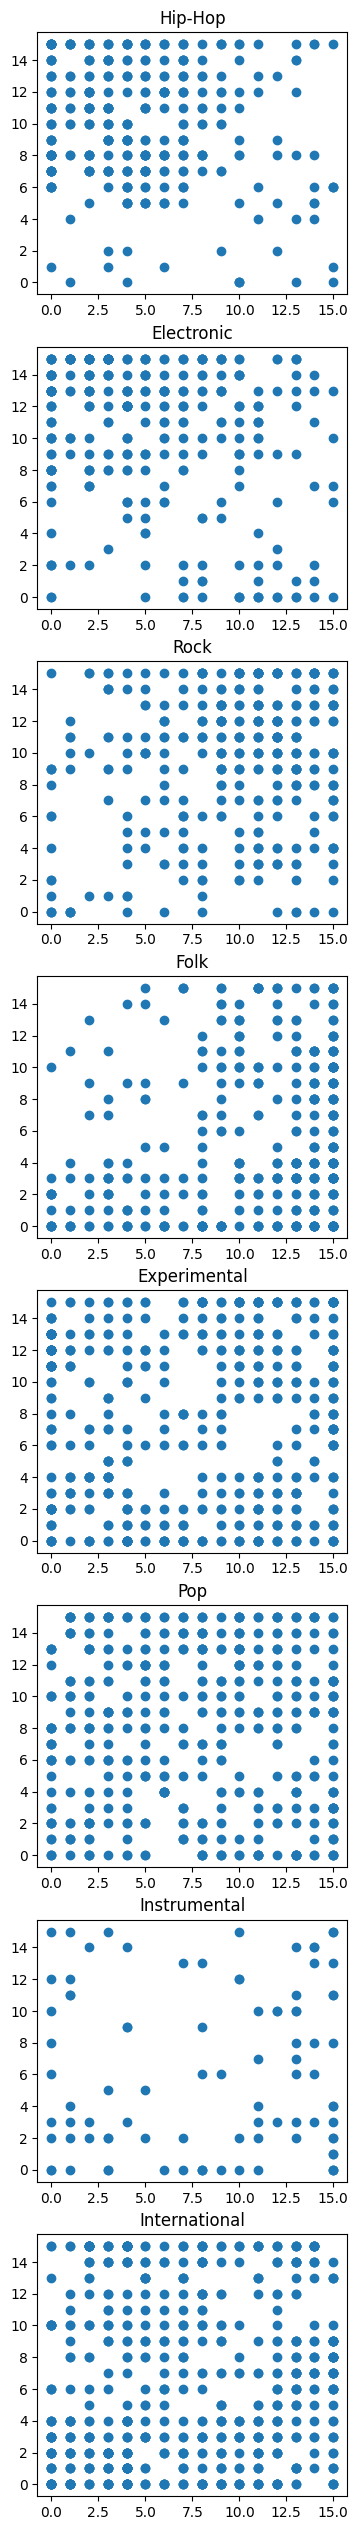

In [ ]:
# @title Display where the fields cluster
fig, axs = plt.subplots(len(fields), figsize=(4,4 * len(fields) ))

for i in range(len(fields)):
  field = fields[i]
  data = field_visualizations[field]
  X = [x['x'] for x in data]
  Y = [x['y'] for x in data]
  axs[i].scatter(X, Y)
  axs[i].set_title(field)

# Visualizing the SOM using Bokeh

In [ ]:
# @title update dataframe
projection = som.transform(test_data)
X = [x[0] for x in projection]
Y = [x[1] for x in projection]

current_df_test['proj_x'] = X
current_df_test['proj_y'] = Y
proj = [[x[0], x[1]] for x in projection]
current_df_test['proj'] = proj

<ipython-input-23-aa718cc94c3a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df_test['proj_x'] = X
<ipython-input-23-aa718cc94c3a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df_test['proj_y'] = Y
<ipython-input-23-aa718cc94c3a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [ ]:
# @title Build Color palette utility { display-mode: "form" }
# @markdown This few line of code are used to build color palette
import random
def build_color_palette(unique):
    result = {}
    for name in unique:
        if type(name).__name__ != 'str':
          if math.isnan(float(name)):
            name = "Unknown"
        # Generating a random number in between 0 and 2^24
        color = random.randrange(0, 2**24)
        # Converting that number from base-10 (decimal) to base-16 (hexadecimal)
        hex_color = hex(color)
        std_color = "#" + hex_color[2:]
        result[name] = std_color
    print(result)
    return result

def assign_colors(df, palette, header):
    colors = []
    for item in df[header]: #this needs to be set in a variable
        if type(item).__name__ != 'str':
          if math.isnan(float(item)):
            item = "Unknown"
        color = palette[item]
        colors.append(color)
    df['colors'] = colors


In [ ]:
# @title List all the Columns of Dataset { display-mode: "form" }
current_df_test.columns.values.tolist()

['id',
 'Info',
 'Description',
 'Genre',
 'album_date_released',
 'track_date_recorded',
 'artist_location',
 'fingerprints',
 'bmus',
 'features',
 'mfcc',
 'proj_x',
 'proj_y',
 'proj']

In [ ]:
# @title Select the field that will be displayed in the visualization
field = "Genre" #@param {type: "string"}
unique_values = current_df_test[field].unique()
print(len(unique_values))
palette = build_color_palette(unique_values)
assign_colors(current_df_test, palette, field)

8
{'Hip-Hop': '#1d68cf', 'Electronic': '#ffce08', 'Rock': '#869ecd', 'Folk': '#1a85eb', 'Experimental': '#e47d64', 'Pop': '#a2d482', 'Instrumental': '#8502b8', 'International': '#95327c'}


<ipython-input-24-8a48b99d20a3>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['colors'] = colors


In [ ]:
# @title List all the unique values of the selected field of the Dataset { display-mode: "form" }
current_df_test[field].unique().tolist()

['Hip-Hop',
 'Electronic',
 'Rock',
 'Folk',
 'Experimental',
 'Pop',
 'Instrumental',
 'International']

In [ ]:
# @title Make test data based on single category { display-mode: "form" }
category = 'Rock' #@param {type:"string"}
test_data = current_df_test.loc[current_df_test[field] == category]

In [ ]:
# @title Make test data based on multiple categories { display-mode: "form" }
# @markdown `please insert the values seprated by a space " "`
category = 'Rock Instrumental Folk' #@param {type:"string"}
category = category.split()
print(category)
test_data = current_df_test.loc[current_df_test[field].isin(category)]

['Rock', 'Instrumental', 'Folk']


In [ ]:
# @title Make test data based on rows from the test dataset { display-mode: "form" }
# @markdown `depending on the dataset you might have smaller boundaries`

# @markdown `so to say less than 199 datapoints`
start = 0 #@param {type:"number"}
end = 199 #@param {type:"number"}
if end > 999:
  end = 999
print(end)
test_data = current_df_test.loc[train_amount + start:train_amount + end]

199


In [ ]:
# @title Build Visualization with Bokeh { display-mode: "form" }


# test_data = projection_df

'''
make a cell for the two lines below to have the
tst data be either specific rows
or specific Genre
'''

# test_data = current_df_test.loc[current_df_test['Genre'] == 'Rock']
# test_data = current_df_test.loc[3000:3699]

TITLE = "SOM Visualization"
TOOLS = "hover,pan,wheel_zoom,box_zoom,reset,save"



p = figure(tools=TOOLS, toolbar_location="above", title=TITLE)
p.toolbar.logo = "grey"
p.background_fill_color = "#efefef"
p.xaxis.axis_label = "X-axis"
p.yaxis.axis_label = "Y-axis"
p.grid.grid_line_color = "white"
p.hover.tooltips = [
    (field, "@" + field),
]


source = ColumnDataSource(test_data)

p.scatter("proj_x", "proj_y", size=12, source=source, color="colors",line_color="black", alpha=0.9)

labels = LabelSet(x="X-axis", y="Y-axis", text="symbol", y_offset=8,
                  text_font_size="11px", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

# show(p) # won't work in colab 😭
# @markdown Type here the name of plot
plotname = '0-199.html' #@param {type: "string"}
# @markdown This will be saved in your GDrive in the same folder where the .pkl files are stored

# @markdown `Note that if you use the same file name the previous plot wil be overwritten`
output_file(plotname)
save(p)


'/content/drive/MyDrive/Colab Notebooks/MAWD/mad-pickles/0-199.html'

## TO DO 
* [x] add save functionality for colab integration from [here](https://docs.bokeh.org/en/latest/docs/reference/io.html#bokeh.io.save)
* [x] make projecting the other datasets possible
* [ ] make downloadable csv files from SOM and DataFrames to be used in JS or other frameworks
* [ ] Add more Pandas filtering methods like [queries](https://datagy.io/pandas-query/), see documentation [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.query.html)
* [ ] remove nans from datasets